In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import torch
from numpy.linalg import norm

## TO DO
1. Find a way to record steps to convergence
2. Write simulation comparison code / Post Processing (in-progress; BP)
3. Apply to real dataset

## FINISHED
1. Write data generating function
2. Write Normal Equation function (theoretical)
3. Define SGD function
4. Define Quasi-Newton's function
5. Define Newton's method
6. Write simulation function

## Functions

In [235]:
#CREATE SIMULATION DATA
# creates feature matrix and corresponding observation.
# y - n x 1 matrix of normal distribution data of mu and sigma
# X - n x m matrix of parameters. First column is the intercept which is always 1
# Each parameter (column) is from the normal distribution of mu and sigma
# default is std norm: mu = 0, sd = 1
def create_sim_data_lr(n,m,mu = 0, sigma = 1):
    y = np.random.normal(mu,sigma,size = (n,1))    
    X = np.random.normal(mu,sigma,size = (n,m))
    X[:,0] = 1
    
    return ((X,y))


### Normal Equation (Theoretical)
# Closed Form Solution
# beta_hat = (X^T %*% X)^-1 %*% X %*% y
def normal_eq_lr(X,y):
    A = np.linalg.inv(np.matmul(np.transpose(X),X))
    B = np.matmul(np.transpose(X),y)
    return(np.matmul(A,B))


### Newton's method
### Adapted partially from https://thatdatatho.com/newtons-method-bfgs-linear-regression/

def Newton(X,y,error = 10**-5,max_iter = 250,tol = 10**-5):
    # Convert from tensor to numpy array
    X = np.array(X)
    y = np.array(y)
    
    m = X.shape[1]
    n = y.shape[0]
    
    
    beta = np.zeros((m,1)) # Start with a guess
    A = -np.transpose(X)
    B = y - np.matmul(X,beta)
    gradient = np.matmul(A,B)
    hessian = np.matmul(np.transpose(X),X)
    
    # Start Newton's method implementation here:
    k = 0
    grads = dict()
    while norm(gradient) > error: # stop if the norm_gradient < error
        if k > max_iter: # stop if iteration number exceeds max iteration limit
            break
        else:
            A = -np.transpose(X)
            B = y - np.matmul(X,beta)
            gradient = np.matmul(A,B)
            try:
                grads[k] = norm(gradient)
                # If norm of gradient cannot be calculated because there's an infinite in there
                # There is no convergence. Return no solution
            except:
                return(torch.from_numpy(np.full((m,1),np.nan)))
                break
            if k >= 1:
                diff = abs(grads[k] - grads[k-1]) # stop if minimal improvement on the previous step
                if diff < tol:
                    break
            hessian = np.matmul(np.transpose(X),X) 
            search = np.matmul(np.linalg.inv(-hessian),gradient)
            beta = beta + search
            prev_beta = beta
            k += 1
    return(torch.from_numpy(beta))


In [236]:
# The func below should prob be used over the create_sim_data_lr above

def sim_lm(n_obs, m_betas, X=None, b=None, seed=None):
    """Simulate a linear model as Xb = y.
    
    Parameters
    ----------
    n_obs : int
        Number of observatins (rows of X).
    m_beta : int
        Numbers of beta weights.
    X : 2d array, optional, default: None
        Features. Defaults to random normal.
    b : 1d array, optional default: None
        Beta weights. Default to random normal.
    seed : int, optional, default: None
        Random seed for reproducibility.
        
    Returns
    -------
    X : 2d tensor
        Features.
    b : 1d tensor
        Beta weights.
    y : 1d tensor
        Target.
    """
    
    # Set seed
    if seed is not None:
        np.random.seed(seed)
           
    # Initalize arrays
    if X is None:
        X = np.random.normal(size=(n_obs, m_betas))
        
    if b is None:
        b = np.random.normal(size=m_betas)

    # Solve y that corresponds to b and X
    y = np.dot(X, b).reshape(-1, 1)
    
    # Torch's linear layers require f32 tensors
    X = X.astype(np.float32)
    b = b.astype(np.float32)
    y = y.astype(np.float32)

    # Create tensors
    X = torch.from_numpy(X)
    b = torch.from_numpy(b)
    y = torch.from_numpy(y)
    
    return X, b, y


# MODELS / TRAINING
class LinearRegression(torch.nn.Module):
    """Muliple linear regression as a perceptron.
    
    Parameters
    ----------
    m_beta : int
        Numbers of beta weights.
    """
    def __init__(self, m_betas):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(m_betas, 1)
        
    def forward(self, x):
        return self.linear(x)


def train_model(X, y, method='SGD', lr=0.01, n_epochs=1000, opt_kwargs=None):
    """Train various gradient descent algorithms.
    
    Parameters
    ----------
    X : 2d tensor
        Features.
    y : 1d tensor
        Target.
    method : {'SGD', 'LBFGS'} # There is no newton implementation for pytorch, had to manually code this
        Model to train.
    lr : float, optional, default: 0.01
        Learning rate (step size).
    n_epochs : int, optional, default: 1000
        Number of training iterations.
    opt_kwargs : dict, optional, default: None
        Optimizers kwargs to pass through to pytorch.
        
    Returns
    -------
    model : LinearRegression
        Trained model.
    loss_hist : 1d array
        Loss per step.
    elapsed : float
        Total time to train and run n_epochs.
    """
    
    # Initalize model and loss function
    model = LinearRegression(len(X[0]))
    loss_func = torch.nn.MSELoss()
    loss_hist = np.zeros(n_epochs)
    
    # Select optimizer
    opt_kwargs = {} if opt_kwargs is None else opt_kwargs
    if method == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, **opt_kwargs)
    elif method == 'LBFGS':
        optimizer = torch.optim.LBFGS(model.parameters(), lr=lr, **opt_kwargs)

    # Closure step function needed for LBFGS
    def closure():

        # Zero gradients
        optimizer.zero_grad()

        # Get predicted y
        y_hat = model(X)

        # Compute loss
        loss = loss_func(y_hat, y)
        
        # Backpropagate and update weights
        loss.backward()
        
        #loss_hist[i] = loss
        
        return loss
    
    # Time
    start = time.time()
    
    # Train
    for i in range(n_epochs):
        
        if method == 'SGD':
            loss = closure()
            optimizer.step()
            loss_hist[i] = loss
        elif method == 'LBFGS':
            loss = optimizer.step(closure)
            loss_hist[i] = loss


    # Time
    end = time.time()
    elapsed = end-start
    
    return model, loss_hist, elapsed


def test_train_model():
    
    """Test 1 beta and 10 beta cases."""
    N = 100
    
    for M in [1, 10]:

        X, b, y = sim_lm(N, M)

        model, loss_hist, elapsed = train_model(X, y, method='SGD')

        assert all(
            model.linear.weight[0].detach().numpy().round(2) == b.numpy().round(2)
        )

    
test_train_model()

## Simulations

The goal of these simulations is to create cases where we have n samples (could be low or high) and m features (1-1000). In the context of an optimization problem, compare the performance between SGD, Newton's method, and Quasi-Newton for each case.

Optimization problems to try: Regression, Classification (maybe if we don't have time, we can stick to regression only)

In [257]:
# Number of simulations
n_sim = 100 

# Number of observations
n = 1000

# Number of features
ms = [1, 10, 100,1000]

# Number of epochs
n_epochs = 250

# Track loss, beta error, and elapsed time
loss_history = {
    'sgd': np.zeros((len(ms), n_sim, n_epochs)),
    'newton': np.zeros((len(ms), n_sim, n_epochs)),
    'lbfgs': np.zeros((len(ms), n_sim, n_epochs))
}

beta_mse = {
    'normal': np.zeros((len(ms), n_sim)),
    'sgd': np.zeros((len(ms), n_sim)),
    'newton': np.zeros((len(ms), n_sim)),
    'lbfgs': np.zeros((len(ms), n_sim))
}

elapsed_time = {
    'normal': np.zeros((len(ms), n_sim)),
    'sgd': np.zeros((len(ms), n_sim)),
    'newton': np.zeros((len(ms), n_sim)),
    'lbfgs': np.zeros((len(ms), n_sim))
}

for im, m in enumerate(ms):
    
    for i in tqdm(range(n_sim)):
        
        # Generate new data
        X, b, y = sim_lm(n, m, seed=i)

        # Normal equation
        start = time.time()
        b_normal = normal_eq_lr(X, y)[:, 0]
        end = time.time()
        
        beta_mse['normal'][im, i] = float(((b_normal-b)**2).mean())
        elapsed_time['normal'][im, i] = end-start
        
        # SGD
        model_sgd, loss_hist_sgd, elapsed_sgd = \
            train_model(X, y, method='SGD', n_epochs=n_epochs)
        
        b_hat_sgd = model_sgd.linear.weight[0]

        beta_mse['sgd'][im, i] = float(((b - b_hat_sgd)**2).sum())
        elapsed_time['sgd'][im, i] = elapsed_sgd
        loss_history['sgd'][im, i] = loss_hist_sgd
        
        # LBFGS  !! this is super slow, either reduce iterations or multiprocess !!
        # Took ~30 seconds for 20 iterations
        # Took ~2 mintutes for each 100 iterations; 1,10,100,1000 betas
        model_lbfgs, loss_hist_lbfgs, elapsed_lbfgs = \
            train_model(X, y, method='LBFGS', n_epochs=n_epochs)
        
        b_hat_lbfgs = model_lbfgs.linear.weight[0]

        beta_mse['lbfgs'][im, i] = float(((b - b_hat_lbfgs)**2).sum())
        elapsed_time['lbfgs'][im, i] = elapsed_lbfgs
        loss_history['lbfgs'][im, i] = loss_hist_lbfgs
        
        # DO NEWTON'S
        start = time.time()
        b_newton = Newton(X,y)[:,0]
        end = time.time()
        
        beta_mse['newton'][im, i] = float(((b_newton-b)**2).mean())
        elapsed_time['newton'][im, i] = end-start

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\bpham\AppData\Local\Temp\ipykernel_238932\619585863.py:60: RuntimeWarning: invalid value encountered in double_scalars
  diff = abs(grads[k] - grads[k-1]) # stop if minimal improvement on the previous step
C:\Users\bpham\AppData\Local\Temp\ipykernel_238932\619585863.py:50: RuntimeWarning: overflow encountered in matmul
  B = y - np.matmul(X,beta)
C:\Users\bpham\AppData\Local\Temp\ipykernel_238932\619585863.py:51: RuntimeWarning: invalid value encountered in matmul
  gradient = np.matmul(A,B)


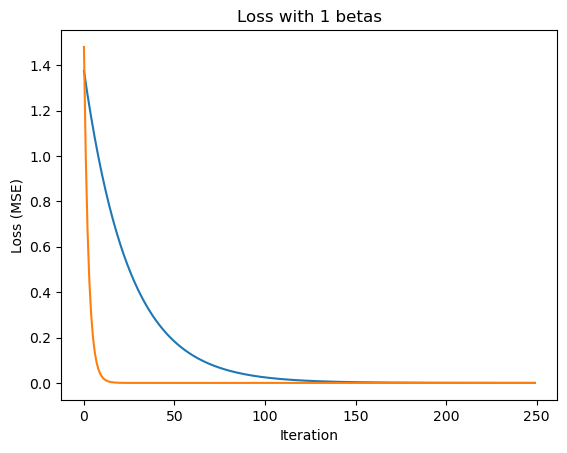

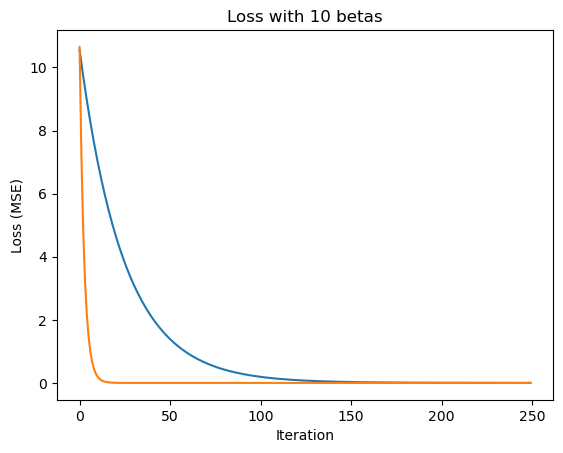

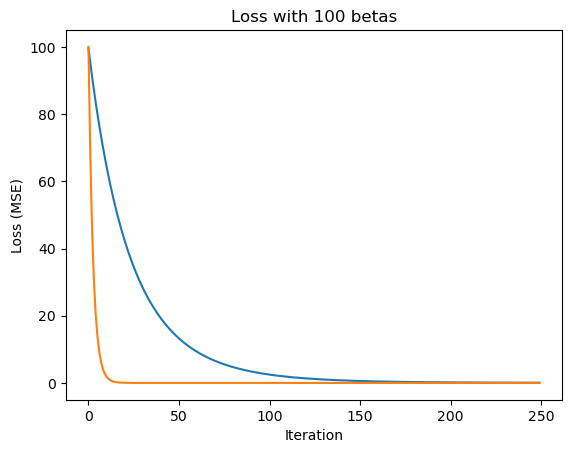

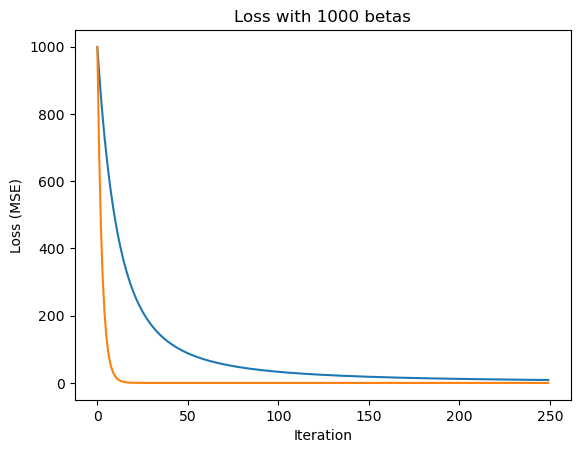

In [258]:
# Loss starts higher as betas increases, but rate of descent is similar
#   We could quantify rate of convergence as the exponential decay rate of loss
for i in range(4):
    plt.figure(i)
    plt.title(f'Loss with {ms[i]} betas')
    plt.plot(loss_history['sgd'][i].mean(axis=0), label='SGD')
    plt.plot(loss_history['lbfgs'][i].mean(axis=0), label='LBFGS')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Iteration')

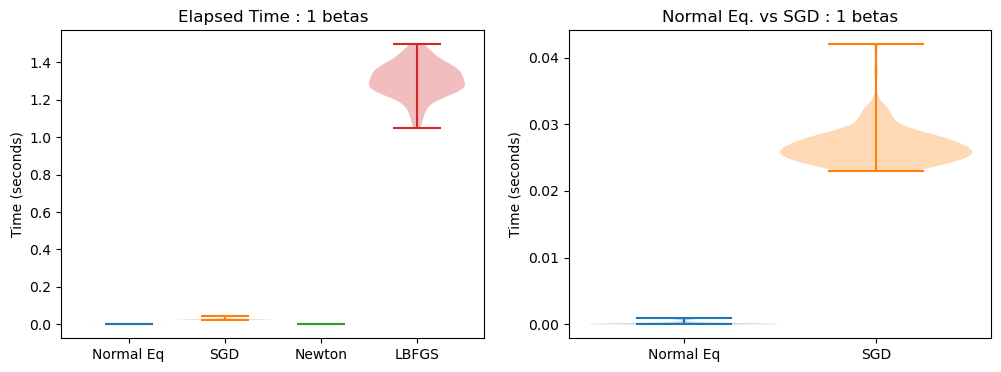

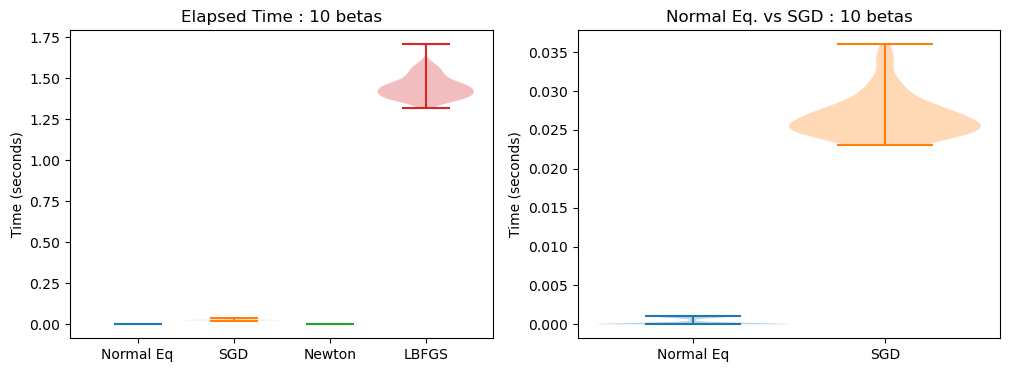

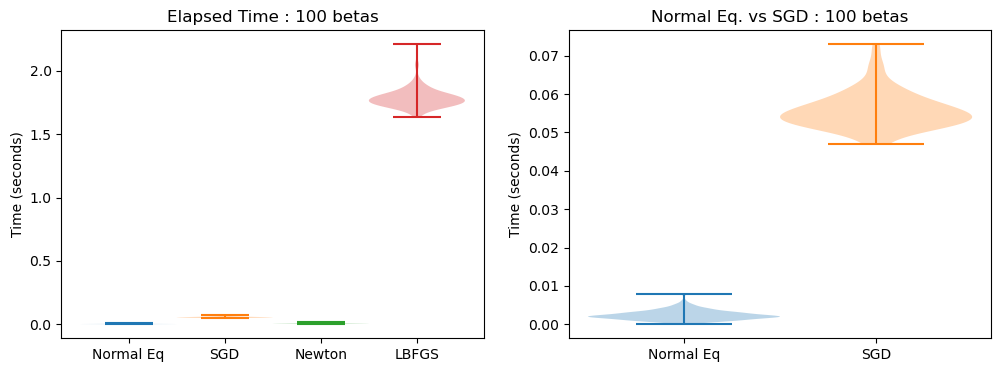

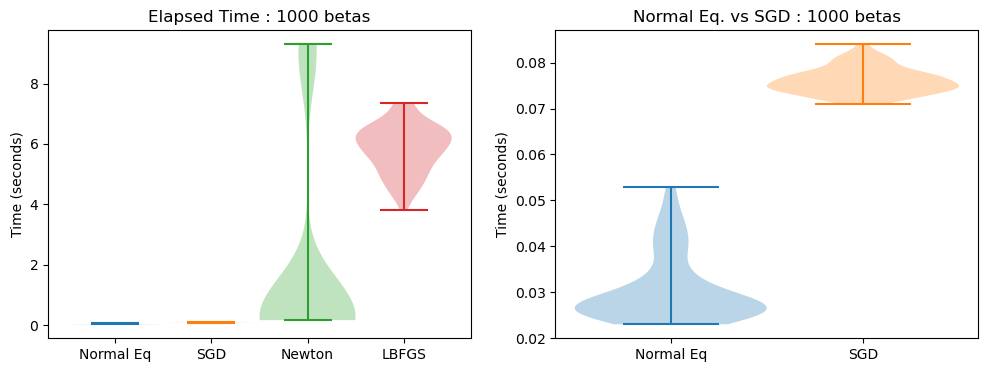

In [259]:
for i in range(4):
    fig, axes = plt.subplots(figsize=(12, 4), ncols=2)
    
    axes[0].violinplot(elapsed_time['normal'][i])
    axes[0].violinplot(elapsed_time['sgd'][i], positions=[1.5])
    axes[0].violinplot(elapsed_time['newton'][i], positions=[2])
    axes[0].violinplot(elapsed_time['lbfgs'][i], positions=[2.5])
    
    axes[1].violinplot(elapsed_time['normal'][i])
    axes[1].violinplot(elapsed_time['sgd'][i], positions=[1.5])
    
    axes[0].set_xticks([1, 1.5, 2,2.5], ['Normal Eq', 'SGD','Newton', 'LBFGS'])
    axes[1].set_xticks([1, 1.5], ['Normal Eq', 'SGD'])
    
    axes[0].set_title(f'Elapsed Time : {ms[i]} betas')
    axes[1].set_title(f'Normal Eq. vs SGD : {ms[i]} betas')
    
    axes[0].set_ylabel('Time (seconds)')
    axes[1].set_ylabel('Time (seconds)')

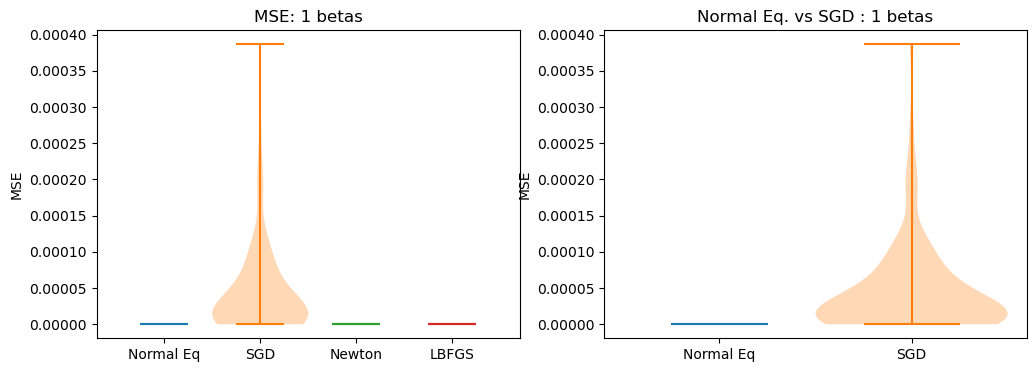

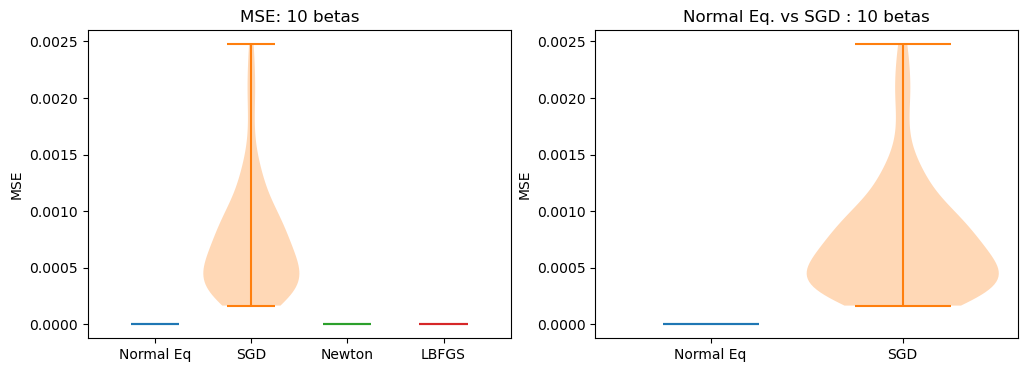

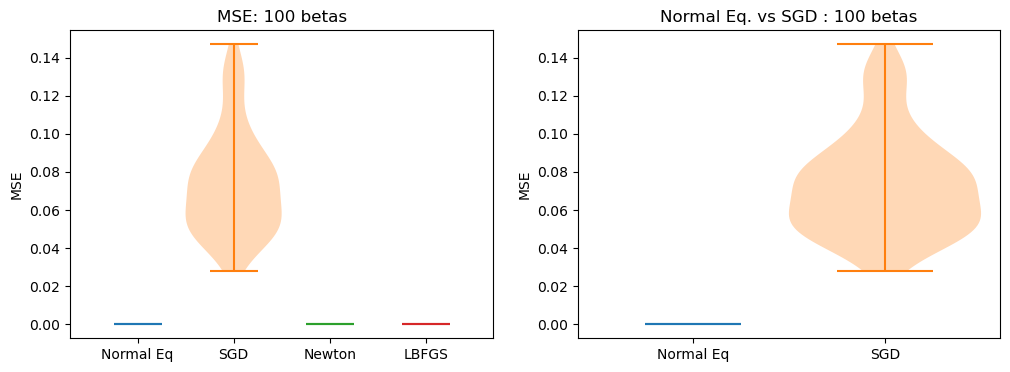

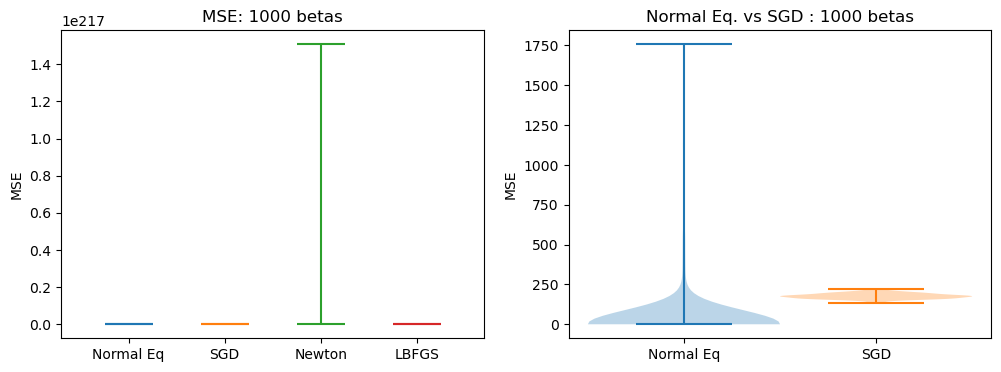

In [260]:
# Plot mse comparison
# helper function to get finite vals in the mse only
# Use this for violin plot visualizations
def get_finite_vals(array):
    ii = np.isfinite(array)
    return(array[ii])


for i in range(4):
    fig, axes = plt.subplots(figsize=(12, 4), ncols=2)
    
    axes[0].violinplot(get_finite_vals(beta_mse['normal'][i]))
    axes[0].violinplot(get_finite_vals(beta_mse['sgd'][i]), positions=[1.5])
    axes[0].violinplot(get_finite_vals(beta_mse['newton'][i]), positions=[2])
    axes[0].violinplot(get_finite_vals(beta_mse['lbfgs'][i]), positions=[2.5])
    
    axes[1].violinplot(get_finite_vals(beta_mse['normal'][i]))
    axes[1].violinplot(get_finite_vals(beta_mse['sgd'][i]), positions=[1.5])
    
    axes[0].set_xticks([1, 1.5, 2,2.5], ['Normal Eq', 'SGD','Newton', 'LBFGS'])
    axes[1].set_xticks([1, 1.5], ['Normal Eq', 'SGD'])
    
    axes[0].set_title(f'MSE: {ms[i]} betas')
    axes[1].set_title(f'Normal Eq. vs SGD : {ms[i]} betas')
    
    axes[0].set_ylabel('MSE')
    axes[1].set_ylabel('MSE')


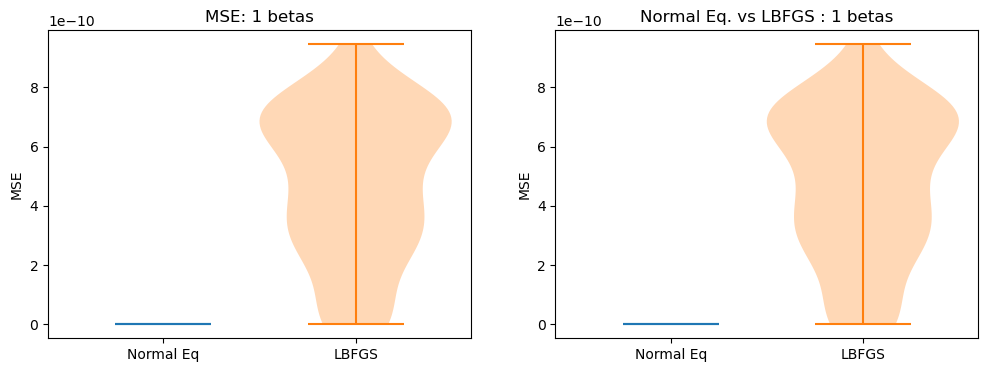

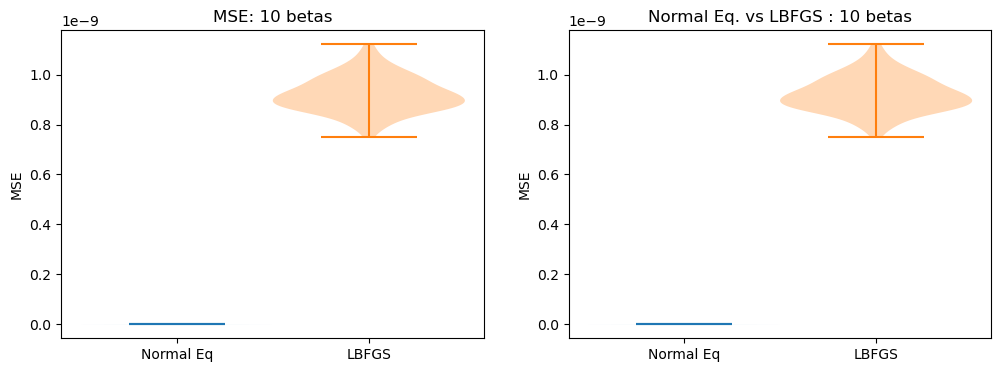

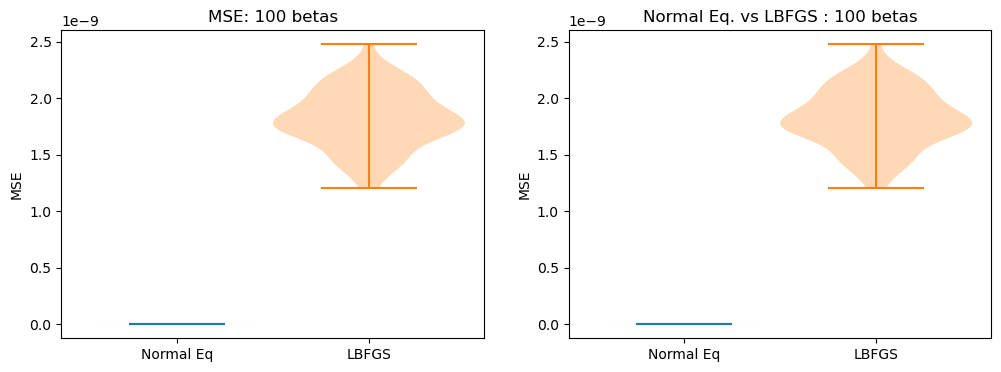

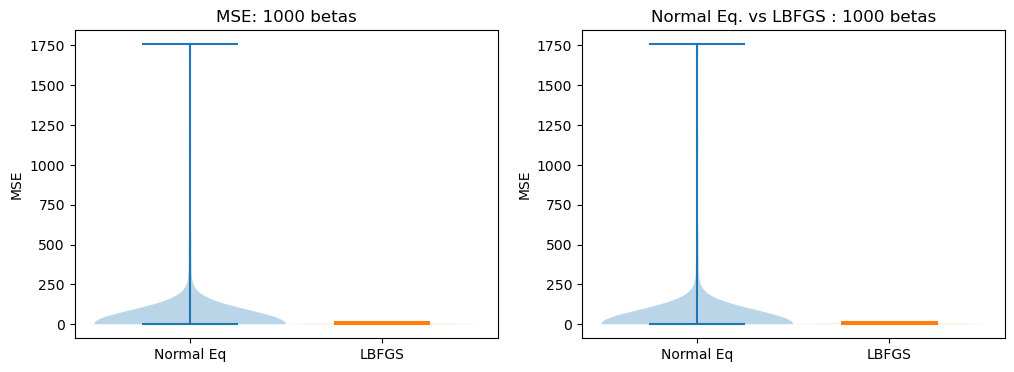

In [274]:
for i in range(4):
    fig, axes = plt.subplots(figsize=(12, 4), ncols=2)
    
    axes[0].violinplot(get_finite_vals(beta_mse['normal'][i]))
    axes[0].violinplot(get_finite_vals(beta_mse['lbfgs'][i]), positions=[1.5])
    
    axes[1].violinplot(get_finite_vals(beta_mse['normal'][i]))
    axes[1].violinplot(get_finite_vals(beta_mse['lbfgs'][i]), positions=[1.5])
    
    axes[0].set_xticks([1, 1.5], ['Normal Eq', 'LBFGS'])
    axes[1].set_xticks([1, 1.5], ['Normal Eq', 'LBFGS'])
    
    axes[0].set_title(f'MSE: {ms[i]} betas')
    axes[1].set_title(f'Normal Eq. vs LBFGS : {ms[i]} betas')
    
    axes[0].set_ylabel('MSE')
    axes[1].set_ylabel('MSE')